<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [57]:
# YOUR CODE HERE
import pandas as pd
past = pd.read_csv('../dat/past.csv.gz', compression='gzip')
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the perspective of classification, is the data balanced?

In [64]:
# YOUR CODE HERE
print(past['Purchased?'].mean())

0.3438


Roughly 34.38% interactions resulted in purchase.

In [68]:
print(past.groupby("Purchased?")['InsessionView'].mean())
print(past.groupby("Purchased?")['InsessionRemove'].mean())
print(past.groupby("Purchased?")['InsessionCart'].mean())

Purchased?
0    15.644532
1    15.274447
Name: InsessionView, dtype: float64
Purchased?
0    25.698774
1    19.884189
Name: InsessionRemove, dtype: float64
Purchased?
0    24.651499
1    19.877436
Name: InsessionCart, dtype: float64


More people appear to windowshop.The data does not appear to be balanced.

3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [36]:
# YOUR CODE HERE
# YOUR CODE HERE
from tkinter.tix import COLUMN

X = past.drop(columns = ['product_id', 'user_id'])
y = X.pop("Purchased?")

In [37]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [41]:
# YOUR CODE HERE
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X.describe()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
pca = PCA(n_components=5, whiten=True)
X_reduced = pca.fit_transform(X_scaled)


In [39]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [40]:
# YOUR CODE HERE
print(pca.explained_variance_ratio_)

[0.10282104 0.0944524  0.06501312 0.05125766 0.04249231]


6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [15]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [42]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

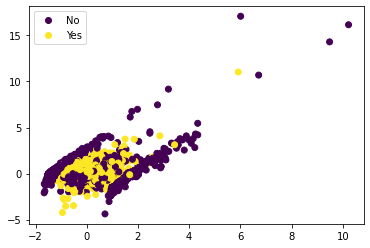

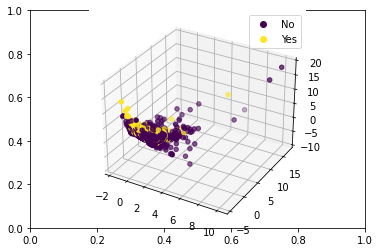

In [43]:
# YOUR CODE HERE
# YOUR CODE HERE
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [44]:
# YOUR CODE HERE (imports!)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train(X, y, standardize = True) -> None:
    # YOUR CODE HERE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    logreg = LogisticRegression(random_state=42, class_weight="balanced").fit(X_train, y_train)
    y_pred =  logreg.predict(X_test)
    print(classification_report(y_test, y_pred))

train(X_reduced, y)

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       659
           1       0.47      0.52      0.49       341

    accuracy                           0.63      1000
   macro avg       0.60      0.61      0.60      1000
weighted avg       0.65      0.63      0.64      1000



Now apply the pipeline on the all the features `X` and review the performance

In [45]:
# YOUR CODE HERE
train(X, y, standardize=True)

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       659
           1       0.54      0.53      0.54       341

    accuracy                           0.69      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.69      0.69      0.69      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [67]:
# YOUR CODE HERE
train(X_reduced, y, standardize=True)

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       659
           1       0.49      0.53      0.51       341

    accuracy                           0.65      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.66      0.65      0.66      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 

*YOUR ANSWER HERE*

 Yes, the results are as expected. The reduced features are performing the same as the original features, despite decreasing the number of features from 34 to 5.

### Pros:
    - Reduced features create take less computational time to train and test the model
    - Reduced features are more interpretable
### Cons:
    - Reduced explainability of the model.

```
    

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [46]:
# YOUR CODE HERE
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [47]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        # YOUR CODE HERE
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        # YOUR CODE HERE
        inertias.append(kmeans.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

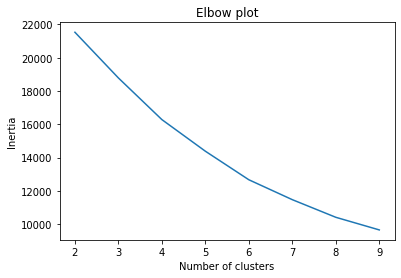

In [19]:
# YOUR CODE HERE
visualize_elbow(X_reduced, range(2,10))

4. What are the disadvantage to use the Elbow method? 

    *YOUR ANSWER HERE*
    
   There does not seem to be a clearly defined "elbow" where the inertia decreases rapidly, therefore is is hard to determine 'optimal' number of clusters from elbow method.

    As is apparent from out solution, the disadvantage of elbow method is that it is very subjective.

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [48]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.1979443004160727
For n_clusters = 3 The average silhouette_score is : 0.210820849085599
For n_clusters = 4 The average silhouette_score is : 0.21747985176066587
For n_clusters = 5 The average silhouette_score is : 0.22257780689138654
For n_clusters = 6 The average silhouette_score is : 0.2043747412402628
For n_clusters = 7 The average silhouette_score is : 0.2058700074663618
For n_clusters = 8 The average silhouette_score is : 0.21463220529101965
For n_clusters = 9 The average silhouette_score is : 0.2205700277395039


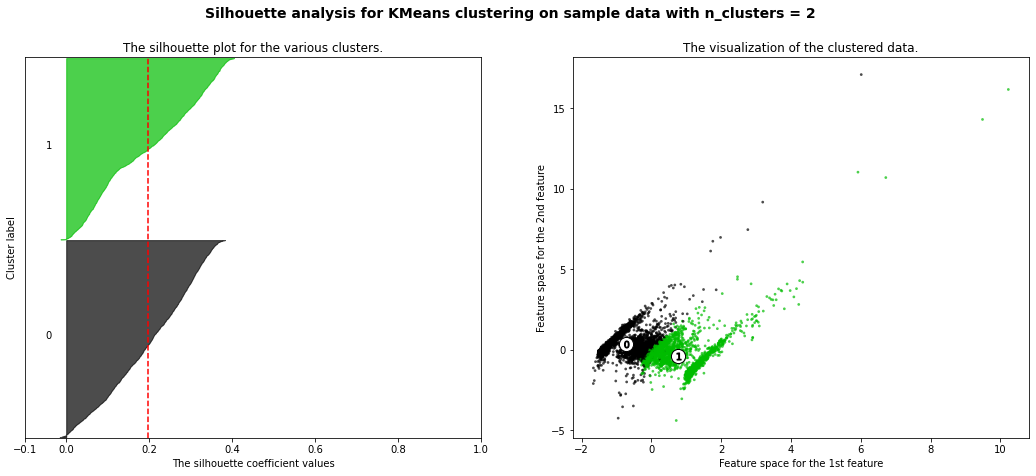

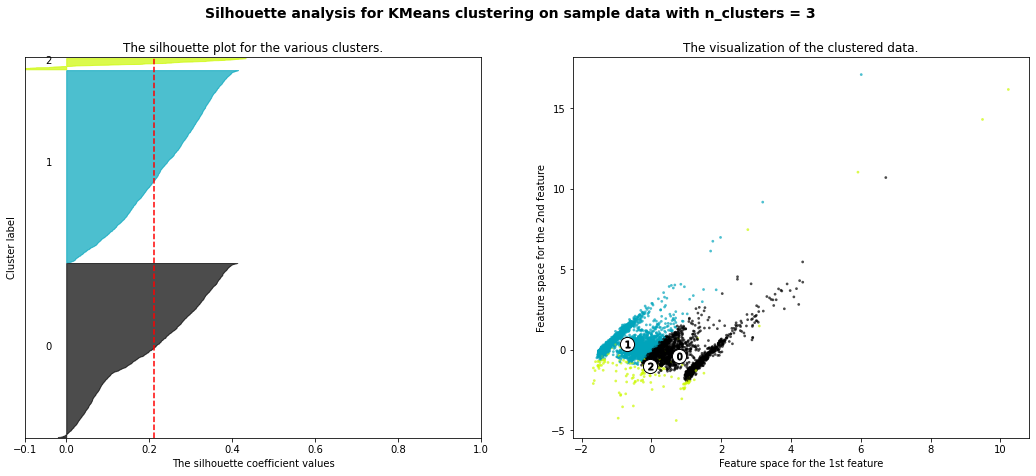

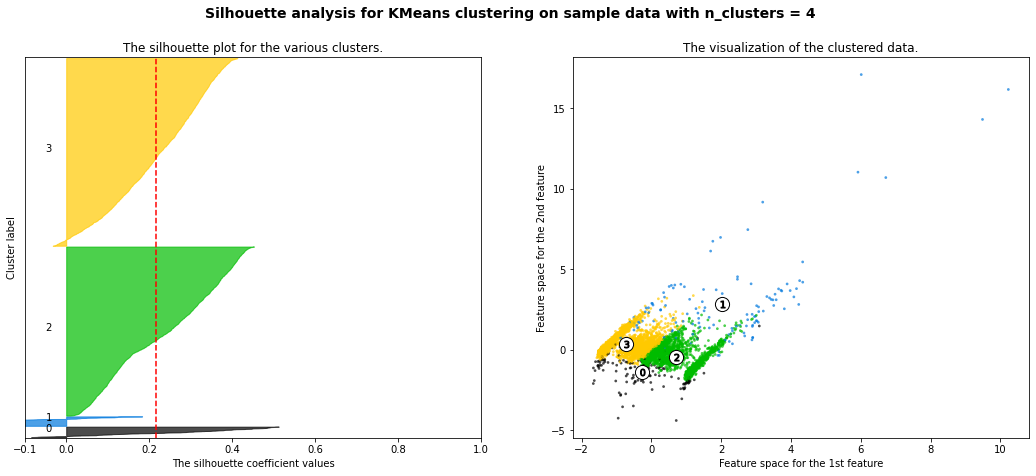

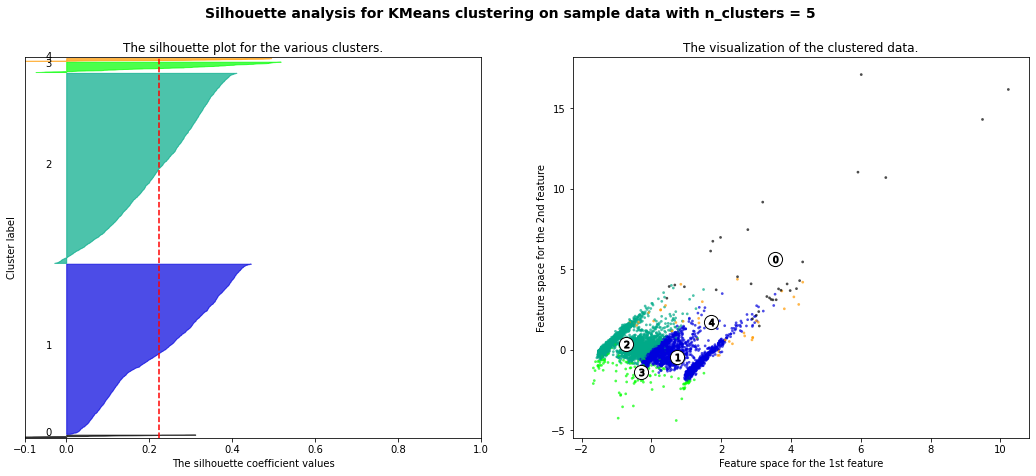

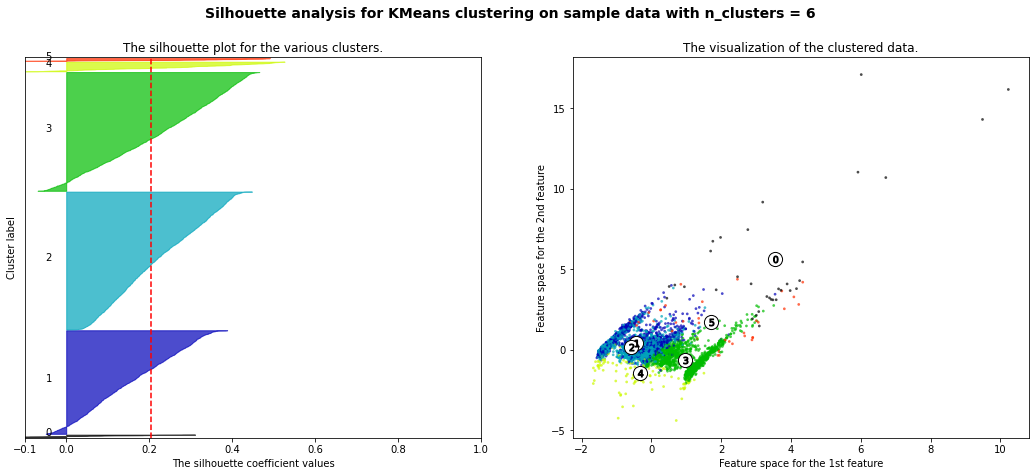

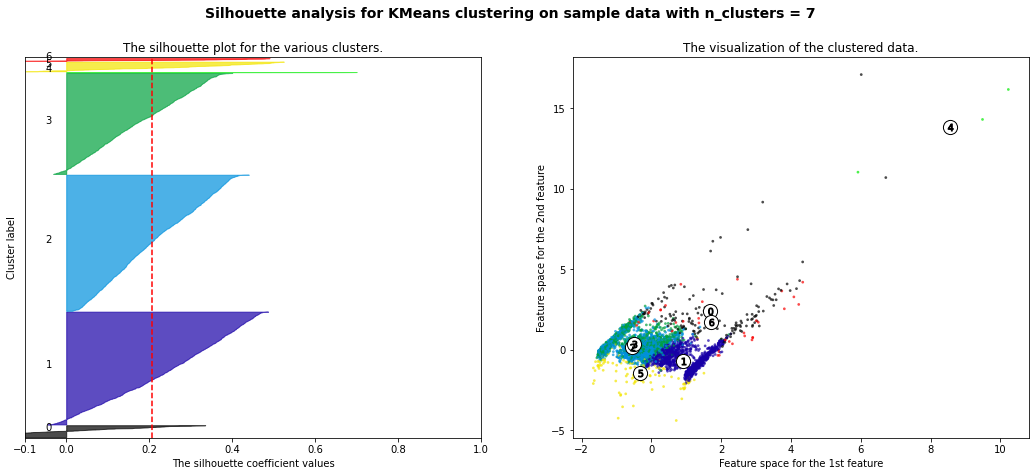

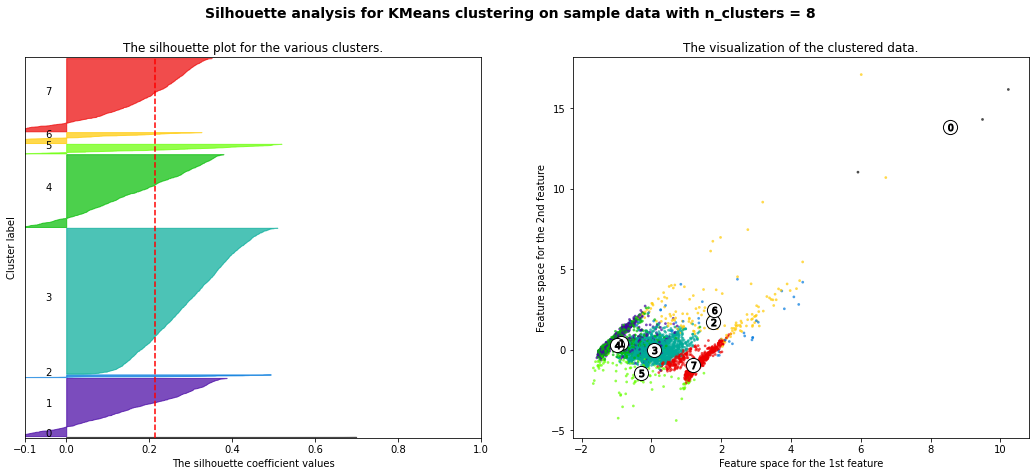

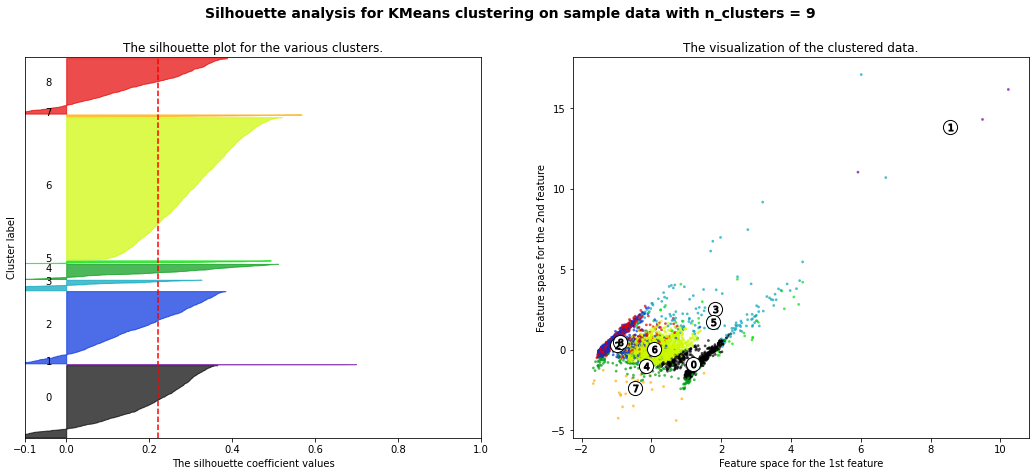

In [71]:
# YOUR CODE HERE
visualize_silhouette(9, X_reduced, random_state=10)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [72]:
# YOUR CODE HERE
km = KMeans(n_clusters=5, random_state=10).fit(X_reduced)

7. What is the size of each cluster? 

In [83]:
# YOUR CODE HERE
print(np.unique(km.labels_))
print(np.bincount(km.labels_))

[0 1 2 3 4]
[  33 2263 2528  138   38]


In [84]:
for i in range(0, len(np.unique(km.labels_))):
    print('Cluster label ', i, 'number of points', np.bincount(km.labels_)[i])

Cluster label  0 number of points 33
Cluster label  1 number of points 2263
Cluster label  2 number of points 2528
Cluster label  3 number of points 138
Cluster label  4 number of points 38


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [79]:
# YOUR CODE HERE
past['cluster_pca'] = km.predict(X_reduced)
past.head(5)

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0,1
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0,1
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0,1
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0,1
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0,2


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

In [85]:
past_np = past.to_numpy().copy()
past_np[1,4]

27556.5

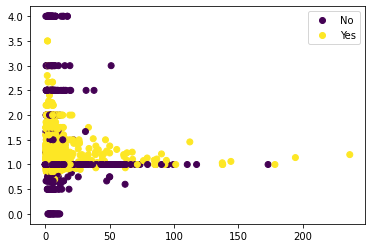

In [87]:
fig, ax = plt.subplots()
plot = plt.scatter(past_np[:,5], past_np[:,36], c=y) # Price x Category
ax.legend(
    handles=plot.legend_elements()[0], 
    labels=['No', 'Yes'])

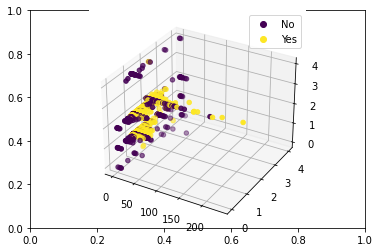

In [89]:
fig, ax = plt.subplots()
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(past_np[:,5], past_np[:,36], past_np[:,37], c=y)  # Price x Category x cluster
ax.legend(
    handles=plot.legend_elements()[0], 
    labels=['No', 'Yes'])

In [90]:
pd.unique(past['Category']).shape

(288,)

In [91]:
past_short = past.drop(columns=['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'minPrice', 'NumCart', 'NumView', 'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Weekend'])

In [92]:
past_short.describe()

,maxPrice,Fr,Mon,Sat,Sun,Thu,Tue,Wed,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,7.457600,0.139367,0.146068,0.131505,0.127727,0.148628,0.152491,0.154214,0.213311,0.065900,0.162676,0.244012,0.169207,0.085550,0.343800,0.059343,1.143728,1.57700
std,11.883206,0.233077,0.239096,0.230588,0.221794,0.237543,0.247173,0.247695,0.275556,0.172911,0.246050,0.289270,0.252342,0.191101,0.475023,0.153912,0.438141,0.59845
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.483750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000
50%,4.440585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,1.000000,2.00000
75%,7.620000,0.200000,0.200000,0.181818,0.181818,0.222222,0.214286,0.217391,0.333333,0.040000,0.250000,0.363636,0.250000,0.090909,1.000000,0.041888,1.045996,2.00000
max,236.510000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.00000


    *YOUR ANSWER HERE*
The majoraty of the convertions are with low price products and category between 1 -2.
There is the need to figure out what is the size of the high price products (need a bigger warehouse, shipment costs) and their margin.
There is a convertion rate of 41% for cluster label_3. Need to find out what are the main caracteristics of this cluster

In [94]:
# YOUR CODE HERE
for i in range(0, len(np.unique(km.labels_))):
    label_x = past.loc[(past['cluster_pca'] == i)]
    print('Label ', i ,'count', label_x['Purchased?'].count(),'Purchased mean', np.round(label_x['Purchased?'].mean(), 3))

Label  0 count 33 Purchased mean 0.121
Label  1 count 2263 Purchased mean 0.33
Label  2 count 2528 Purchased mean 0.36
Label  3 count 138 Purchased mean 0.406
Label  4 count 38 Purchased mean 0.053


In [95]:
past.loc[(past['cluster_pca'] == 3)].describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,1.380000e+02,1.380000e+02,138.000000,138.000000,1.380000e+02,138.000000,138.000000,138.000000,138.000000,138.000000,...,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
mean,5.460966e+06,5.344107e+08,1.450607,1.173008,9.887982e+04,60.671329,60.620730,0.122522,1.219377,0.073375,...,0.226249,0.055750,0.195095,0.191918,0.177298,0.065633,0.405797,0.088057,1.052504,3.0
std,1.443358e+06,5.544309e+07,0.651459,0.278345,2.085459e+05,33.580139,33.573251,0.226943,0.409165,0.185282,...,0.248606,0.146290,0.252362,0.230127,0.238903,0.150364,0.492835,0.195865,0.176834,0.0
min,5.379000e+03,1.439953e+08,1.000000,1.000000,0.000000e+00,32.300000,32.300000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,3.0
25%,5.787387e+06,5.145922e+08,1.000000,1.000000,0.000000e+00,39.520000,39.341224,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.0
50%,5.864252e+06,5.464178e+08,1.287931,1.033333,4.907500e+02,48.420000,48.320000,0.000000,1.105556,0.000000,...,0.185855,0.000000,0.133333,0.136533,0.132055,0.000000,0.000000,0.000000,1.000000,3.0
75%,5.892420e+06,5.658671e+08,1.639286,1.243622,1.248199e+05,66.582500,66.582500,0.179422,1.342949,0.041229,...,0.333333,0.064538,0.275078,0.291118,0.247283,0.083761,1.000000,0.072074,1.039233,3.0
max,5.931773e+06,6.151285e+08,6.200000,3.000000,1.299567e+06,236.510000,236.510000,1.500000,4.400000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.500000,3.0


In [96]:
past.describe()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
count,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,5.573727e+06,5.235286e+08,1.951080,1.327052,2.490234e+05,7.457600,7.426321,0.541953,0.893687,0.413592,...,0.213311,0.065900,0.162676,0.244012,0.169207,0.085550,0.343800,0.059343,1.143728,1.57700
std,1.161840e+06,5.998702e+07,1.324727,0.718266,6.920382e+05,11.883206,11.876266,0.565350,0.841036,0.772170,...,0.275556,0.172911,0.246050,0.289270,0.252342,0.191101,0.475023,0.153912,0.438141,0.59845
min,4.104000e+03,6.524181e+07,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,5.760491e+06,4.998498e+08,1.000000,1.000000,0.000000e+00,2.483750,2.480000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000
50%,5.830816e+06,5.343735e+08,1.750000,1.166667,3.626375e+03,4.440585,4.440000,0.500000,1.000000,0.222222,...,0.142857,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,1.000000,2.00000
75%,5.875312e+06,5.616843e+08,2.308355,1.500000,2.071993e+05,7.620000,7.550000,0.858766,1.000000,0.632775,...,0.333333,0.040000,0.250000,0.363636,0.250000,0.090909,1.000000,0.041888,1.045996,2.00000
max,5.932538e+06,6.220262e+08,40.000000,28.000000,1.087537e+07,236.510000,236.510000,12.000000,28.000000,38.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.00000


10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

    *YOUR ANSWER HERE*
    Given that two clusters appear to be much larger than other clusters, K-means might not be best for this problem.

In [77]:
# YOUR CODE HERE

11. Jot down recommendations or followup steps, detailing the reasons.

    *YOUR ANSWER HERE*

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [97]:
# YOUR CODE HERE
new = pd.read_csv("../dat/new.csv.gz")
new.shape

(30091, 5)

In [98]:
assert new.shape == (30091, 5)

In [99]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

In [101]:
print(past.shape)
print(new.shape)

(5000, 38)
(30091, 5)


        *YOUR ANSWER HERE*

    *The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [102]:
# YOUR CODE HERE
print(f"Number of product ids in both past and new data: {len(np.intersect1d(past.product_id, new.product_id))}")

Number of product ids in both past and new data: 0


4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [103]:
# YOUR CODE HERE # ~.344
new["Purchased?"].mean()

0.3442557575354757

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [104]:
# YOUR CODE HERE
X = new.drop(["product_id"], axis=1)
y = X.pop("Purchased?")

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting dataframes into ndarrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [105]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [106]:
# YOUR CODE HERE
clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      3909
           1       0.81      0.51      0.63      2110

    accuracy                           0.79      6019
   macro avg       0.79      0.72      0.74      6019
weighted avg       0.79      0.79      0.77      6019



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [107]:
# YOUR CODE HERE
X = np.concatenate((X_train, X_test, past[X.columns].to_numpy()), axis=0)

In [108]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [109]:
# YOUR CODE HERE
y = np.concatenate((-1*np.ones(y_train.shape), -1*np.ones(y_test.shape), past["Purchased?"].to_numpy()))

In [110]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [111]:
# YOUR CODE HERE
from sklearn.semi_supervised import LabelSpreading

ssl = LabelSpreading(kernel='knn', alpha=0.01)
ssl.fit(X, y)

LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [112]:
semi_sup_preds = ssl.transduction_[X_train.shape[0]:X_train.shape[0]+X_test.shape[0]] # YOUR CODE HERE

In [113]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [114]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3909
           1       0.80      0.59      0.68      2110

    accuracy                           0.80      6019
   macro avg       0.80      0.76      0.77      6019
weighted avg       0.80      0.80      0.80      6019



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      3909
           1       0.81      0.51      0.63      2110

    accuracy                           0.79      6019
   macro avg       0.79      0.72      0.74      6019
weighted avg       0.79      0.79      0.77      6019



    *YOUR ANSWER HERE*

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)